In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as spio

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

# loading scripts from here
from evaluation import accuracy
from evaluation import areaundercurve
from evaluation import average_precision_score_computation

"""
This is an implementation from:
https://github.com/tkipf/pygcn/blob/master/pygcn/layers.py

Author: Thomas kipf
Paper: 
Semi-Supervised Classification with Graph Convolutional Networks
https://arxiv.org/abs/1609.02907
"""

from GCNConv import GraphConvolution

Using matplotlib backend: agg


In [2]:
"""
This is an implementation from:
https://github.com/tkipf/pygcn/blob/master/pygcn/models.py

Model and training settings are from:
https://github.com/tkipf/pygcn/blob/master/pygcn/train.py
which is the same as reported from the paper.

Author: Thomas kipf
"""
class Net(torch.nn.Module):
    def __init__(self, in_channel, out_channel, data):
        super(Net, self).__init__()

        self.gc1 = GraphConvolution(in_channel, 16)
        self.gc2 = GraphConvolution(16, out_channel)
        
        injection = torch.ones_like(data.adj) * 0.001
        injection = torch.abs(injection)
        self.injection = torch.nn.Parameter(
            injection, 
            requires_grad=True
        )

    def forward(self, data):
        x, adj = data.x, data.adj
        
        # link injection
        injection = F.relu(self.injection)
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
        
        # forward passing
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [3]:
from tqdm import tqdm

NUMEPOCHS = 10000
early_stop_win_size = 100
earliest_stop = 5000
tolerance = 0.02

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data
name = 'CiteSeer'
dataset = Planetoid('../datasets/'+ name, name=name)

in_dim = dataset.num_node_features
out_dim = dataset.num_classes

data = dataset.data
data.adj = to_dense_adj(add_self_loops(data.edge_index)[0])[0]
data = dataset.data.to(device)

# compile model
model = Net(
    in_dim,
    out_dim,
    data
).to(device)

# optimizer = torch.optim.Adam(model.parameters(), weight_decay=5e-4, lr=0.01)
optimizer = torch.optim.Adamax(model.parameters(), weight_decay=5e-4, lr=0.01)

In [4]:
# get the initial injection
injection_init = model.injection.detach().cpu().numpy()

In [5]:
# record accuracy
train_acc = np.zeros(NUMEPOCHS)
val_acc = np.zeros(NUMEPOCHS)
test_acc = np.zeros(NUMEPOCHS)

# training start
model.train()

for epoch in range(NUMEPOCHS):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    # record the accuracy
    train_acc[epoch] = accuracy(model, data, 'train')
    val_acc[epoch] = accuracy(model, data, 'val')
    test_acc[epoch] = accuracy(model, data, 'test')
    
    # early stopping
    if epoch > max(2 * early_stop_win_size, earliest_stop):
        prev_start = epoch - 2 * early_stop_win_size
        prev_end = epoch - early_stop_win_size
        current_start = epoch - early_stop_win_size
        current_end = epoch
        
        val_acc_current = np.mean(val_acc[current_start: current_end])
        val_acc_previous = np.mean(val_acc[prev_start: prev_end])
        
#         if val_acc_current < val_acc_previous - tolerance:
        if val_acc_current < np.max(val_acc) - tolerance:
            train_acc = train_acc[:epoch]
            val_acc = val_acc[:epoch]
            test_acc = test_acc[:epoch]
            print('Moving Average Early stopping at %d-th epoch' % epoch)
            print(
                'Previous validation average accuracy for %d-th to %d-th epoch: %f' % \
                (prev_start, prev_end, val_acc_previous)
            )
            print(
                'Current validation average accuracy for %d-th to %d-th epoch: %f' % \
                (current_start, current_end, val_acc_current)
            )
            break
    if epoch % 1000 == 0:
        print(
            epoch, 
            'training acc =', train_acc[epoch], 
            'validation acc =', val_acc[epoch], 
            ', loss =', loss.item()
        )

0 training acc = 0.25 validation acc = 0.22 , loss = 16.648670196533203
1000 training acc = 1.0 validation acc = 0.298 , loss = 0.0013094226596876979
2000 training acc = 1.0 validation acc = 0.322 , loss = 0.0008326888200826943
3000 training acc = 1.0 validation acc = 0.348 , loss = 0.0004927555564790964
4000 training acc = 1.0 validation acc = 0.42 , loss = 0.00027681191568262875
5000 training acc = 1.0 validation acc = 0.536 , loss = 0.00018848577747121453
6000 training acc = 1.0 validation acc = 0.63 , loss = 0.00013516744365915656
7000 training acc = 1.0 validation acc = 0.666 , loss = 0.00011569658818189055
8000 training acc = 1.0 validation acc = 0.668 , loss = 0.00011680126044666395
9000 training acc = 1.0 validation acc = 0.676 , loss = 0.0001169522583950311


In [6]:
# get the initial injection
injection_final = F.relu(model.injection.detach()).cpu().numpy()

In [7]:
print('Initial injection = \n', injection_init)
print('\nSum inital = %d\n' % np.sum(injection_init))
print('Final injection = \n', injection_final)
print('\nSum final = %d\n' % np.sum(injection_final))

Initial injection = 
 [[0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 ...
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]]

Sum inital = 11068

Final injection = 
 [[4.6614587e-06 0.0000000e+00 0.0000000e+00 ... 4.2878608e-03
  3.6191498e-06 0.0000000e+00]
 [0.0000000e+00 6.3306530e-08 0.0000000e+00 ... 4.1373005e-06
  8.0991675e-05 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.1686514e-05
  0.0000000e+00 4.1023092e-03]
 ...
 [1.2000973e-04 1.7580033e-04 4.0630355e-05 ... 1.8591472e-06
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.2323738e-05 5.3777949e-05 1.2781828e-04 ... 4.6157143e-06
  0.0000000e+00 0.0000000e+00]]

Sum final = 886



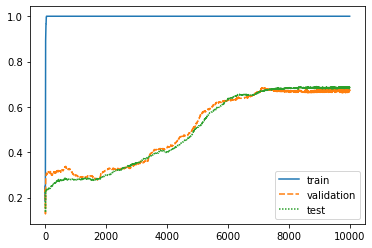

In [8]:
df_acc = pd.DataFrame({
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

sns.lineplot(data=df_acc)
plt.show()

In [9]:
spio.savemat('../variables/' + name + '/GCNConv.mat',{
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

In [10]:
print('Train Accuracy: {:.4f}'.format(accuracy(model, data, 'train')))
print('Validation Accuracy: {:.4f}'.format(accuracy(model, data, 'val')))
print('Test Accuracy: {:.4f}'.format(accuracy(model, data, 'test')))

Train Accuracy: 1.0000
Validation Accuracy: 0.6740
Test Accuracy: 0.6840


In [11]:
print('Test AUC: {:.4f}'.format(areaundercurve(model,data,'test')))

Test AUC: 0.7977


In [12]:
test_acc_all = [0.7080, 0.6890, 0.6810, 0.6840, 0.6740]
test_auc_all = [0.7992, 0.8017, 0.7926, 0.7972, 0.7938]

print(np.mean(test_acc_all))
print(np.mean(test_auc_all))

print(np.std(test_acc_all))
print(np.std(test_auc_all))

0.6872
0.7969
0.01147867588182536
0.003362142174269267
